## Boiler Plate

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing libaries

In [2]:
import pandas as pd
import pickle
import numpy as np
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
from lshash.lshash import LSHash
from PIL import Image
from tqdm import tqdm_notebook
pd.set_option('display.max_columns', 500)

In [3]:
path = Path('../data/caltech101/')

## Loading Data and Model

In [11]:
tfms = get_transforms(
    do_flip=False, 
    flip_vert=False, 
    max_rotate=0, 
    max_lighting=0, 
    max_zoom=1, 
    max_warp=0
)
data = (ImageItemList.from_folder(path)
        .random_split_by_pct(0.2)
        .label_from_folder()
        .transform(tfms=tfms, size=224)
        .databunch(bs=64))

In [12]:
learn = create_cnn(data, models.resnet34, pretrained=True, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


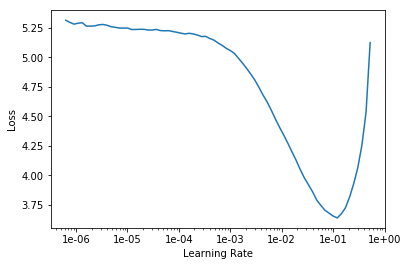

In [13]:
## Finding Ideal learning late
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy
1,1.231863,0.637849,0.813457
2,0.953340,0.717851,0.793217
3,0.594997,0.435635,0.870350
4,0.312876,0.288400,0.923961
5,0.167321,0.221888,0.935449


In [15]:
learn.save('stg1-rn34')

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


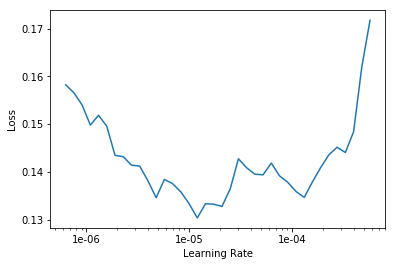

In [17]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,accuracy
1,0.171239,0.322182,0.914114
2,0.269676,0.328862,0.913567
3,0.161636,0.277909,0.924508
4,0.064038,0.189500,0.943107
5,0.033633,0.182829,0.944201


In [93]:
learn.save('stg2-rn34')

## Extracting Feature

Creating a hook right after convolutional part of resnet 50 and max pooling layer which generates a 4096 length vector for a particular image of 256*256.

In [28]:
# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        
sf = SaveFeatures(learn.model[1][5]) ## Output before the last FC layer

Creating Feature Vector

In [32]:
## By running this feature vectors would be saved in sf variable initated above
_= learn.get_preds(data.train_ds)
_= learn.get_preds(DatasetType.Valid)

Converting in a dictionary of {img_path:featurevector}

In [34]:
feature_dict = dict(zip(list(data.train_ds.items)+list(data.valid_ds.items),sf.features))

In [35]:
## Exporting as pickle
pickle.dump(feature_dict, open(path/"feature_dict.p", "wb"))

## Using Locality Sensitive hashing to find near similar images

In [36]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))

In [41]:
## Locality Sensitive Hashing
# params
k = 10 # hash size
L = 5  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=path)

In [113]:
## Exporting as pickle
pickle.dump(lsh, open(path/'lsh.p', "wb"))

## Visualizing Output

In [4]:
## Loading Feature dictionary
feature_dict = pickle.load(open(path/'feature_dict.p','rb'))
lsh = pickle.load(open(path/'lsh.p','rb'))

def get_similar_item(idx, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                     num_results=n_items+1, distance_func='cosine')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            img = Image.open(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

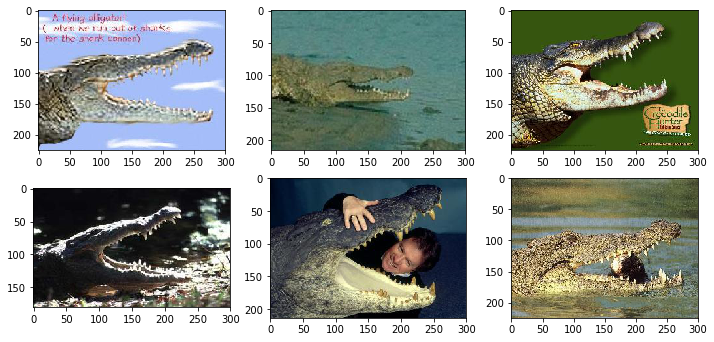

In [5]:
get_similar_item(0, feature_dict, lsh,5)

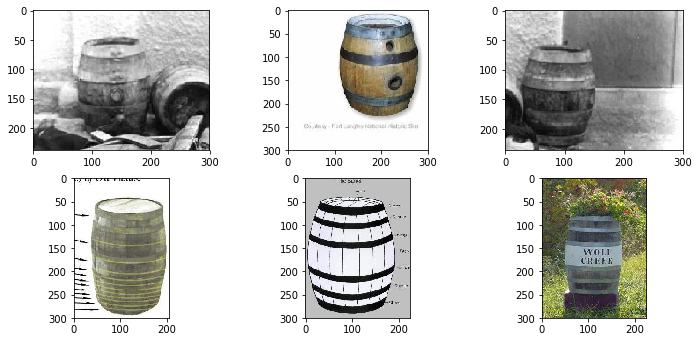

In [6]:
get_similar_item(1000, feature_dict, lsh,5)

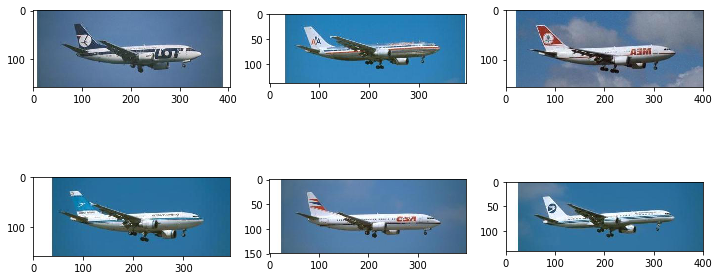

In [7]:
get_similar_item(2000, feature_dict, lsh,5)

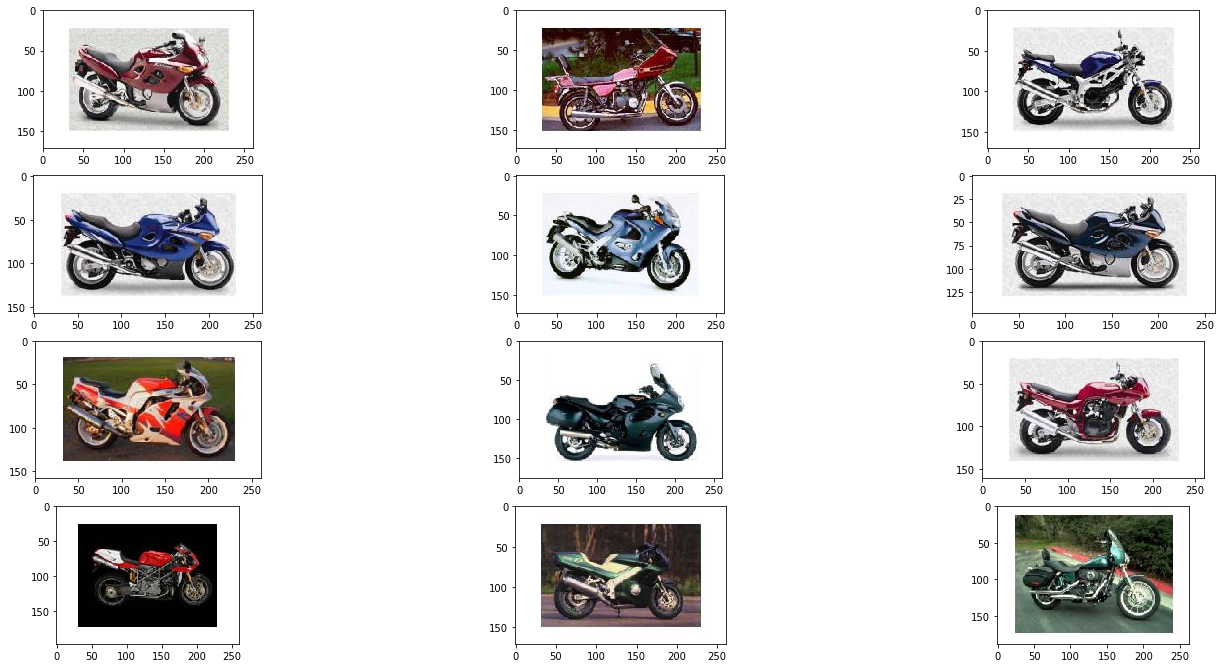

In [8]:
get_similar_item(3000, feature_dict, lsh,11)